In [ ]:
!git clone https://github.com/Soumik-Roy/Robustness-of-Bayesian-Neural-Networks-against-White-Box-Attacks.git

Cloning into 'Robustness-of-Bayesian-Neural-Networks-against-White-Box-Attacks'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 102 (delta 26), reused 69 (delta 9), pack-reused 0
Receiving objects: 100% (102/102), 924.32 KiB | 7.90 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
!cp -a Robustness-of-Bayesian-Neural-Networks-against-White-Box-Attacks/. ./

In [ ]:
!rm -r ./Robustness-of-Bayesian-Neural-Networks-against-White-Box-Attacks

In [ ]:
import os 
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet
from models.NonBayesianModels.AlexNet import AlexNet
from models.NonBayesianModels.LeNet import LeNet
from models.NonBayesianModels.ThreeConvThreeFC import ThreeConvThreeFC
import data
import utils
import metrics
import config_frequentist as cfg
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
!pip install torchattacks

     |████████████████████████████████| 105 kB 9.0 MB/s 


In [ ]:
from torchattacks import PGD

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def getModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    elif (net_type == 'alexnet'):
        return AlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return ThreeConvThreeFC(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')


def test_model(net, criterion, test_loader):
    valid_loss = 0.0
    net.eval()
    accs = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.detach(), target))
    return valid_loss, np.mean(accs)


In [ ]:
net_type = "lenet"
dataset = "MNIST"
n_epochs = cfg.n_epochs
lr = cfg.lr
num_workers = cfg.num_workers
valid_size = cfg.valid_size
batch_size = cfg.batch_size
criterion = nn.CrossEntropyLoss()


In [ ]:
!mkdir adv_data

In [ ]:
trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)
model = getModel(net_type, inputs, outputs).to(device)

ckpt_dir = f'checkpoints/{dataset}/frequentist'
ckpt_name = f'checkpoints/{dataset}/frequentist/model_{net_type}.pt'
model.load_state_dict(torch.load(ckpt_name))
model = model.eval().cuda()
optimizer = Adam(model.parameters(), lr=lr)
lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
atk = PGD(model, eps=8/255, alpha=2/255, steps=7)
atk.set_return_type('int') # Save as integer.
atk.save(data_loader=test_loader, save_path="adv_data/mnist_pgd.pt", verbose=True)

In [ ]:
test_loss, test_acc = test_model(model, criterion, test_loader)

test_loss = test_loss/len(test_loader.dataset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(test_loss)
print(test_acc)

0.2484176315844059
0.95185546875


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
adv_images, adv_labels = torch.load("adv_data/mnist_pgd.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)

In [ ]:
adv_loss, adv_acc = test_model(model, criterion, adv_loader)

adv_loss = adv_loss/len(adv_loader.dataset)
print(adv_loss)
print(adv_acc)

2.514749061203003
0.20703125


In [ ]:
from torch.nn import functional as F

def BPGD(model, criterion, len, image,labels, eps=0.3, alpha=2/255, iters=40,num_ens=1) :
    # images = images.to(device)
    # labels = labels.to(device)
    # loss = nn.CrossEntropyLoss()
        
    # ori_images = images.data
    training_loss = 0.0
    accs = []
    kl_list = []
    for i in range(iters) :  
          inputs= image.to(device)
          labels=labels.to(device)
          outputs = torch.zeros(inputs.shape[0], model.num_classes, num_ens).to(device)
          inputs.requires_grad = True
          kl = 0.0
          for j in range(num_ens):
              net_out, _kl = model(inputs)
              kl += _kl
              outputs[:, :, j] = F.log_softmax(net_out, dim=1)
          
          kl = kl / num_ens
          kl_list.append(kl.item())
          log_outputs = utils.logmeanexp(outputs, dim=2)

          beta = 1/ len
          loss = criterion(log_outputs, labels, kl, beta)
          loss.backward()
          inputs = inputs + alpha*inputs.grad.sign()
          eta = torch.clamp(adv_images - inputs, min=-eps, max=eps)
          inputs = torch.clamp(inputs + eta, min=0, max=1).detach_()
    return inputs

    # for i in range(iters) :    
    #     images.requires_grad = True
    #     outputs = model(images)

    #     model.zero_grad()
    #     cost = loss(outputs, labels).to(device)
    #     cost.backward()

    #     adv_images = images + alpha*images.grad.sign()
    #     eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
    #     images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    # return images

In [ ]:
import config_bayesian as cfg2

def getModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')
net_type = "lenet"
dataset = "MNIST"
layer_type = cfg2.layer_type
activation_type = cfg2.activation_type
priors = cfg2.priors
criterion = metrics.ELBO(len(test_loader)).to(device)

train_ens = cfg2.train_ens
valid_ens = cfg2.valid_ens
n_epochs = cfg2.n_epochs
lr_start = cfg2.lr_start
num_workers = cfg2.num_workers
valid_size = cfg2.valid_size
batch_size = cfg2.batch_size
beta_type = cfg2.beta_type

trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)

model2 = getModel(net_type, inputs, outputs, priors, layer_type, activation_type).to(device)

ckpt_dir = f'checkpoints/{dataset}/bayesian'
ckpt_name = f'checkpoints/{dataset}/bayesian/model_{net_type}_{layer_type}_{activation_type}.pt'

model2.load_state_dict(torch.load(ckpt_name))
model2 = model2.eval().cuda()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:

correct = 0
total = 0


for images, labels in test_loader:
    model2.train()
    btest_loss=0.0
    btest_accs=[]
    adv_images = BPGD(model2,criterion,len(test_loader),images,labels, eps=8/255, alpha=2/255, iters=100)
    labels = labels.to(device)
    outputs = torch.zeros(adv_images.shape[0], model2.num_classes, 1).to(device)
    kl = 0.0
    for j in range(1):
        net_out, _kl = model2(adv_images)
        kl += _kl
        outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

    log_outputs = utils.logmeanexp(outputs, dim=2)

    criterion = metrics.ELBO(len(test_loader)).to(device)
    
    beta = 1/ len(test_loader)
    btest_loss += criterion(log_outputs, labels, kl, beta).item()
    btest_accs.append(metrics.acc(log_outputs, labels))

print( btest_loss/len(test_loader), np.mean(btest_accs))

In [ ]:
!python testadv_b --dataset MNIST --attack PGD

python3: can't open file 'testadv_b': [Errno 2] No such file or directory


In [ ]:
# !pip install torchattacks
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'torchattacks', 'matplotlib'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import sys

sys.path.insert(0, "BayesianPyTorch") # to include ../helper_evaluate.py etc.


import os 
# os.chdir("/content/")
from torch.nn import functional as F

from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet
from models.NonBayesianModels.AlexNet import AlexNet
from models.NonBayesianModels.LeNet import LeNet
from models.NonBayesianModels.ThreeConvThreeFC import ThreeConvThreeFC

import os.path
import data
import utils
import metrics

import config_bayesian as cfg2
import config_frequentist as cfg

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from torchattacks import PGD, FGSM
import gzip,tarfile


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getBModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def getFModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    elif (net_type == 'alexnet'):
        return AlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return ThreeConvThreeFC(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = 1/len(validloader)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def test_model(net, criterion, test_loader):
    valid_loss = 0.0
    net.eval()
    accs = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.detach(), target))
    return valid_loss, np.mean(accs)
    
def BPGD(model, criterion, len, image,labels, eps=0.3, alpha=2/255, iters=40,num_ens=1) :
    # images = images.to(device)
    # labels = labels.to(device)
    # loss = nn.CrossEntropyLoss()
        
    # ori_images = images.data
    training_loss = 0.0
    accs = []
    kl_list = []
    for i in range(iters) :  
          inputs= image.to(device)
          labels=labels.to(device)
          outputs = torch.zeros(inputs.shape[0], model.num_classes, num_ens).to(device)
          inputs.requires_grad = True
          kl = 0.0
          for j in range(num_ens):
              net_out, _kl = model(inputs)
              kl += _kl
              outputs[:, :, j] = F.log_softmax(net_out, dim=1)
          
          kl = kl / num_ens
          kl_list.append(kl.item())
          log_outputs = utils.logmeanexp(outputs, dim=2)

          beta = 1/ len
          loss = criterion(log_outputs, labels, kl, beta)
          loss.backward()
          adv_images = inputs + alpha*inputs.grad.sign()
          eta = torch.clamp(adv_images - inputs, min=-eps, max=eps)
          images = torch.clamp(inputs + eta, min=0, max=1).detach_()
    return images

def test_attack_freq(freq,dataset,test_loader,inputs,outputs,attack):
    # n_epochs = cfg.n_epochs
    attack_dir=f'adv_data/frequentist/{attack}'
    battack_dir=f'adv_data/bayesian/{attack}'

    if not os.path.exists(attack_dir):
      os.makedirs(attack_dir)
    if not os.path.exists(battack_dir):
      os.makedirs(battack_dir)
    lr = cfg.lr

    criterion = nn.CrossEntropyLoss()
    dict={}
    
    for model in freq:
        fmodel = getFModel(model, inputs, outputs).to(device)
        ckpt_name = f'checkpoints/{dataset}/frequentist/model_{model}.pt'
        fmodel.load_state_dict(torch.load(ckpt_name))
        fmodel = fmodel.eval().cuda()
        test_loss, test_acc = test_model(fmodel, criterion, test_loader)
        # for step in range(0,100,10):
        # print("freq - ",model)
        pgdstep=[]
        accuracies=[]
        for eps in range(0,11,1): 
            epsilon=np.round(eps*0.05, 2)
            badv_dir=f'adv_data/frequentist/{attack}/{dataset}_{model}_{epsilon}_{attack}.pt.tar'
            if attack=='PGD':
              atk = PGD(fmodel, eps=epsilon, alpha=lr, steps=20)
            if attack=='FGSM':
              atk= FGSM(fmodel, eps=epsilon)
            if attack=='BIM':
              atk = BIM(fmodel, eps=epsilon, alpha=lr, steps=20)
            if attack=='PGDL2':
              atk = PGDL2(fmodel, eps=epsilon, alpha=15/255, steps=10, random_start=False)
            atk.set_return_type('int') # Save as integer.
            adv_dir=f'adv_data/bayesian/{attack}/{dataset}_{model}_{epsilon}_{attack}.pt.tar'
            if not os.path.exists(adv_dir):
              atk.save(data_loader=test_loader, save_path=adv_dir, verbose=False)
              atk.save(data_loader=test_loader, save_path=badv_dir, verbose=False)
            # test_loss = test_loss/len(test_loader.dataset)
            
            adv_images, adv_labels = torch.load(adv_dir)
            adv_data = TensorDataset(adv_images.float()/255, adv_labels)
            adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)
            adv_loss, adv_acc = test_model(fmodel, criterion, adv_loader)
            pgdstep.append(epsilon)
            accuracies.append(adv_acc)
            # print("Step", step, "Accuracy", adv_acc)
            
        dict[model]={"accu":accuracies, 'epsilon':pgdstep}
    return dict       
def test_attack_bayes(bay,dataset,test_loader,inputs,outputs,attack):
    layer_type = cfg2.layer_type
    activation_type = cfg2.activation_type
    priors = cfg2.priors
    criterion = metrics.ELBO(len(test_loader)).to(device)

    train_ens = cfg2.train_ens
    valid_ens = cfg2.valid_ens
    n_epochs = cfg2.n_epochs
    lr_start = cfg2.lr_start
    num_workers = cfg2.num_workers
    valid_size = cfg2.valid_size
    batch_size = cfg2.batch_size
    beta_type = cfg2.beta_type
    
    # valid_size = cfg2.valid_size
    # batch_size = cfg2.batch_size
    
    # trainset, testset, inputs, outputs = data.getDataset(dataset)
    # train_loader, valid_loader, test_loader = data.getDataloader(
    #         trainset, testset, valid_size, batch_size, num_workers)
    dict={}
    for model in bay:
        # print("Bay - ",model)
        ckpt_name = f'checkpoints/{dataset}/bayesian/model_{model[1:]}_{layer_type}_{activation_type}.pt'
        # print(ckpt_name)
        bmodel = getBModel(model[1:], inputs, outputs, priors, layer_type, activation_type).to(device)
    
        # ckpt_dir = f'checkpoints/{dataset}/bayesian'
        bmodel.load_state_dict(torch.load(ckpt_name))
        bmodel = bmodel.eval().cuda()
        pgdstep=[]
        accuracies=[] 
        # for step in [40]: 
        for eps in range(0,11,1):  
            # adv_dir=f'adv_data/frequentist/{dataset}_{model[1:]}_{step}_PGD.pt'
            epsilon=np.round(eps*0.05,2)
            adv_dir=f'adv_data/bayesian/{attack}/{dataset}_{model[1:]}_{epsilon}_{attack}.pt.tar'
            if os.path.exists(adv_dir):
            # atk.save(data_loader=test_loader, save_path=adv_dir, verbose=True)
            # test_loss = test_loss/len(test_loader.dataset)
              adv_images, adv_labels = torch.load(adv_dir)
              adv_data = TensorDataset(adv_images.float()/255, adv_labels)
              adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)
              adv_loss, adv_acc =  validate_model(bmodel, criterion, adv_loader, num_ens=valid_ens, beta_type=beta_type)
              pgdstep.append(epsilon)
              accuracies.append(adv_acc)
            # print("Step", step, "Accuracy", adv_acc)
        dict[model]={"accu":accuracies, 'epsilon':pgdstep}
    return dict
        #     correct = 0
        #     total = 0
        #     for images, labels in test_loader:
        #         # model2.train()
        #         # btest_loss=0.0
        #         # btest_accs=[]
        #         # adv_images = BPGD(model2,criterion,len(test_loader),images,labels, eps=0.03, alpha=cfg.lr, iters=step)
        #         # labels = labels.to(device)
        #         adv_images, adv_labels = torch.load(adv_dir)
        #         adv_data = TensorDataset(adv_images.float()/255, adv_labels)
        #         adv_loader = DataLoader(adv_data, batch_size=cfg.batch_size, shuffle=False)
        #         adv_loss, adv_acc = test_model(fmodel, criterion, adv_loader)
        #         pgdstep.append(step)
        #         accuracies.append(adv_acc)
        #         print("Step", step, "Accuracy". adv_acc)
        #         # outputs = torch.zeros(adv_images.shape[0], model2.num_classes, 1).to(device)
        #         # kl = 0.0
        #         # for j in range(1):
        #         #     net_out, _kl = model2(adv_images)
        #         #     kl += _kl
        #         #     outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
            
        #         # log_outputs = utils.logmeanexp(outputs, dim=2)
            
        #         # criterion = metrics.ELBO(len(test_loader)).to(device)
                
        #         # beta = 1/ len(test_loader)
        #         # btest_loss += criterion(log_outputs, labels, kl, beta).item()
        #         # btest_accs.append(metrics.acc(log_outputs, labels))
            
        #     pgdstep.append(step)
        #     accuracies.append(np.mean(btest_accs))
        # dict[model]={"accu":accuracies, 'steps':pgdstep}
           

def plot_PGD(dic_1,dic_2,attack,dataset):
    
    fmodels= dic_1.keys() 
    bmodels= dic_2.keys()
    for f in fmodels:
        dic=dic_1[f]
        x=dic['epsilon']
        y=dic['accu']
        # print(f,y)
        plt.plot(x, y, label=f, marker='o')
        
    for b in bmodels:
        dic=dic_2[b]
        x=dic['epsilon']
        y=dic['accu']
        plt.plot(x, y, label=b, marker='v')
    title=f'{dataset} - {attack} epsilon'
    save=f'att_figure/{dataset}_{attack}_epsilon.png'
    plt.title(title)
    plt.legend(loc='upper right', frameon=False)
    plt.xlabel('Epsilon')
    plt.ylabel('Test Accuracy')
    plt.savefig(save)
        
def test(dataset,attack):
    freq=[]
    bay=[]
    layer_type = cfg2.layer_type
    activation_type = cfg2.activation_type
    for model in ['alexnet','lenet']:
        fckpt_name = f'checkpoints/{dataset}/frequentist/model_{model}.pt'
        bckpt_name = f'checkpoints/{dataset}/bayesian/model_{model}_{layer_type}_{activation_type}.pt'
        if os.path.exists(fckpt_name):
            freq.append(model)
        if os.path.exists(bckpt_name):
            bay.append('B'+model)
    
    valid_size = cfg.valid_size
    batch_size = cfg.batch_size
    num_workers = cfg.num_workers
    
    trainset, testset, inputs, outputs = data.getDataset(dataset,'alexnet')
    train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, valid_size, batch_size, num_workers)
    

    dict_1 = dict_2 = {}
    dict_1=test_attack_freq(freq,dataset,test_loader,inputs,outputs,attack)
    dict_2=test_attack_bayes(bay,dataset,test_loader,inputs,outputs,attack)
    plot_PGD(dict_1,dict_2,attack,dataset)

    # if attack=='FGSM':
    #     dict_1 = dict_2 = {}
    #     dict_1=test_attack_PGD_freq(freq,dataset,test_loader,inputs,outputs)
    #     dict_2=test_attack_PGD_bayes(bay,dataset,test_loader,inputs,outputs)
    #     plot_PGD(dict_1,dict_2)
    
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description = "Test Gradient-Based attack")
#     parser.add_argument('--dataset', default='MNIST', type=str, help='dataset = [MNIST/CIFAR10]')
#     parser.add_argument('--attack',default='PGD', type=str, help='attack = [PGD/FGSM]')
#     args = parser.parse_args()
    
# test('MNIST','FGSM')
test('MNIST','PGD')



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


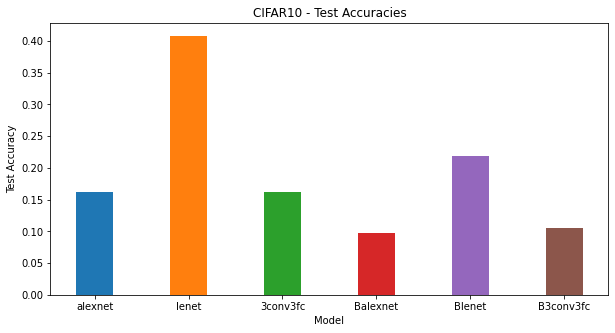

In [ ]:

import os 
from torch.nn import functional as F

from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet
from models.NonBayesianModels.AlexNet import AlexNet
from models.NonBayesianModels.LeNet import LeNet
from models.NonBayesianModels.ThreeConvThreeFC import ThreeConvThreeFC

import os.path
import data
import utils
import metrics

import config_bayesian as cfg2
import config_frequentist as cfg

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getBModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def getFModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    elif (net_type == 'alexnet'):
        return AlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return ThreeConvThreeFC(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = 1/len(validloader)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def test_model(net, criterion, test_loader):
    valid_loss = 0.0
    net.eval()
    accs = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.detach(), target))
    return valid_loss, np.mean(accs)
    
def BPGD(model, criterion, len, image,labels, eps=0.3, alpha=2/255, iters=40,num_ens=1) :
    training_loss = 0.0
    accs = []
    kl_list = []
    for i in range(iters) :  
          inputs= image.to(device)
          labels=labels.to(device)
          outputs = torch.zeros(inputs.shape[0], model.num_classes, num_ens).to(device)
          inputs.requires_grad = True
          kl = 0.0
          for j in range(num_ens):
              net_out, _kl = model(inputs)
              kl += _kl
              outputs[:, :, j] = F.log_softmax(net_out, dim=1)
          
          kl = kl / num_ens
          kl_list.append(kl.item())
          log_outputs = utils.logmeanexp(outputs, dim=2)

          beta = 1/ len
          loss = criterion(log_outputs, labels, kl, beta)
          loss.backward()
          adv_images = inputs + alpha*inputs.grad.sign()
          eta = torch.clamp(adv_images - inputs, min=-eps, max=eps)
          images = torch.clamp(inputs + eta, min=0, max=1).detach_()
    return images

def test_attack_freq(freq,dataset,test_loader,inputs,outputs):
  
    lr = cfg.lr

    criterion = nn.CrossEntropyLoss()
    dict={}
    
    for model in freq:
        fmodel = getFModel(model, inputs, outputs).to(device)
        ckpt_name = f'checkpoints/{dataset}/frequentist/model_{model}.pt'
        fmodel.load_state_dict(torch.load(ckpt_name))
        fmodel = fmodel.eval().cuda()
        test_loss, test_acc = test_model(fmodel, criterion, test_loader)
        dict[model]={"accu":test_acc, 'model':model}
    return dict       
def test_attack_bayes(bay,dataset,test_loader,inputs,outputs):
    layer_type = cfg2.layer_type
    activation_type = cfg2.activation_type
    priors = cfg2.priors
    criterion = metrics.ELBO(len(test_loader)).to(device)

    train_ens = cfg2.train_ens
    valid_ens = cfg2.valid_ens
    n_epochs = cfg2.n_epochs
    lr_start = cfg2.lr_start
    num_workers = cfg2.num_workers
    valid_size = cfg2.valid_size
    batch_size = cfg2.batch_size
    beta_type = cfg2.beta_type
  
    dict={}
    for model in bay:
        ckpt_name = f'checkpoints/{dataset}/bayesian/model_{model[1:]}_{layer_type}_{activation_type}.pt'
        bmodel = getBModel(model[1:], inputs, outputs, priors, layer_type, activation_type).to(device)
    
        bmodel.load_state_dict(torch.load(ckpt_name))
        bmodel = bmodel.eval().cuda()
        test_loss, test_acc =validate_model(bmodel, criterion, test_loader, num_ens=valid_ens, beta_type=beta_type) 
        dict[model]={"accu":test_acc, 'model':model}
    return dict

def plot_PGD(dic_1,dic_2,dataset):
    fig = plt.figure(figsize = (10, 5))
    fmodels= dic_1.keys() 
    bmodels= dic_2.keys()
    for f in fmodels:
        dic=dic_1[f]
        x=dic['model']
        y=dic['accu']
        # print(f,y)
        plt.bar(x, y, width = 0.4)
        
    for b in bmodels:
        dic=dic_2[b]
        x=dic['model']
        y=dic['accu']
        plt.bar(x, y, width = 0.4)

    title=f'{dataset} - Test Accuracies'
    save=f'att_figure/{dataset}_Test_Accuracies.png'
    plt.xlabel("Model")
    plt.ylabel("Test Accuracy")
    plt.title(title)
    # plt.show()
    plt.savefig(save)
        
def test(dataset):
    freq=[]
    bay=[]
    layer_type = cfg2.layer_type
    activation_type = cfg2.activation_type
    for model in ['alexnet','lenet','3conv3fc']:
        fckpt_name = f'checkpoints/{dataset}/frequentist/model_{model}.pt'
        bckpt_name = f'checkpoints/{dataset}/bayesian/model_{model}_{layer_type}_{activation_type}.pt'
        if os.path.exists(fckpt_name):
            freq.append(model)
        if os.path.exists(bckpt_name):
            bay.append('B'+model)
    
    valid_size = cfg.valid_size
    batch_size = cfg.batch_size
    num_workers = cfg.num_workers
    
    trainset, testset, inputs, outputs = data.getDataset(dataset,'alexnet')
    train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, valid_size, batch_size, num_workers)    

    dict_1 = dict_2 = {}
    dict_1=test_attack_freq(freq,dataset,test_loader,inputs,outputs)
    dict_2=test_attack_bayes(bay,dataset,test_loader,inputs,outputs)
    plot_PGD(dict_1,dict_2,dataset)
    
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description = "Test Gradient-Based attack")
#     parser.add_argument('--dataset', default='MNIST', type=str, help='dataset = [MNIST/CIFAR10]')
#     parser.add_argument('--attack',default='PGD', type=str, help='attack = [PGD/FGSM]')
#     args = parser.parse_args()
    
# test('MNIST','FGSM')
test('CIFAR10')



In [ ]:
!python test_acc.py --dataset MNIST

Parameters initialized
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!pip install torchinfo
import os 
from torchsummary import summary
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getBModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def getFModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    elif (net_type == 'alexnet'):
        return AlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return ThreeConvThreeFC(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

for model in ['alexnet','lenet','3conv3fc']:
        freq=[]
        bay=[]
        layer_type = cfg2.layer_type
        activation_type = cfg2.activation_type
        fckpt_name = f'checkpoints/CIFAR10/frequentist/model_{model}.pt'
        bckpt_name = f'checkpoints/CIFAR10/bayesian/model_{model}_lrt_{activation_type}.pt'
        if os.path.exists(fckpt_name):
            freq.append(model)
        if os.path.exists(bckpt_name):
            bay.append('B'+model)
        # for model in freq:
        #   ckpt_name = f'checkpoints/CIFAR10/frequentist/model_{model}.pt'
        #   fmodel = getFModel(model, 3, 10).to(device)
        #   fmodel.load_state_dict(torch.load(ckpt_name))
        #   print(fmodel)
        layer_type = cfg2.layer_type
        activation_type = cfg2.activation_type
        priors = cfg2.priors
        criterion = metrics.ELBO(10).to(device)

        train_ens = cfg2.train_ens
        valid_ens = cfg2.valid_ens
        n_epochs = cfg2.n_epochs
        lr_start = cfg2.lr_start
        num_workers = cfg2.num_workers
        valid_size = cfg2.valid_size
        batch_size = cfg2.batch_size
        beta_type = cfg2.beta_type
        
        # valid_size = cfg2.valid_size
        # batch_size = cfg2.batch_size
        
        # trainset, testset, inputs, outputs = data.getDataset(dataset)
        # train_loader, valid_loader, test_loader = data.getDataloader(
        #         trainset, testset, valid_size, batch_size, num_workers)
        dict={}
        for model in freq:
            fmodel = getFModel(model, 1, 10).to(device)
            ckpt_name = f'checkpoints/MNIST/frequentist/model_{model}.pt'
            fmodel.load_state_dict(torch.load(ckpt_name))
            summary(fmodel, (1, 32, 32))
        # print(bay)
        # for model in ['lenet']:
        #     # print("Bay - ",model)
        #     ckpt_name = f'checkpoints/MNIST/bayesian/model_{model[1:]}_lrt_{activation_type}.pt'
        #     # print(ckpt_name)
        #     bmodel = getBModel(model[1:], 3, 10, priors, layer_type, activation_type).to(device)
        #     batch_size = 256
        #     summary(bmodel, input_size=(3, 32, 32))
        #     # ckpt_dir = f'checkpoints/{dataset}/bayesian'
        #     print(bmodel)
            # summary(bmodel, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]           7,808
              ReLU-2             [-1, 64, 8, 8]               0
              ReLU-3             [-1, 64, 8, 8]               0
           Dropout-4             [-1, 64, 8, 8]               0
         MaxPool2d-5             [-1, 64, 4, 4]               0
            Conv2d-6            [-1, 192, 4, 4]         307,392
              ReLU-7            [-1, 192, 4, 4]               0
              ReLU-8            [-1, 192, 4, 4]               0
         MaxPool2d-9            [-1, 192, 2, 2]               0
           Conv2d-10            [-1, 384, 2, 2]         663,936
             ReLU-11            [-1, 384, 2, 2]               0
             ReLU-12            [-1, 384, 2, 2]               0
          Dropout-13            [-1, 384, 2, 2]               0
           Conv2d-14            [-1, 25

In [ ]:
from torch.nn import Parameter
Parameter(torch.Tensor(5,4,*(3,3)))

Parameter containing:
tensor([[[[ 1.6892e-34,  0.0000e+00, -9.3279e+35],
          [ 4.5853e-41, -8.9325e+35,  4.5853e-41],
          [-3.5393e+35,  4.5853e-41, -3.1077e+35]],

         [[ 4.5853e-41, -1.6265e+34,  4.5853e-41],
          [-1.0999e+34,  4.5853e-41, -1.3268e+34],
          [ 4.5853e-41, -3.5962e+35,  4.5853e-41]],

         [[-3.5730e+35,  4.5853e-41, -4.6126e+35],
          [ 4.5853e-41, -5.2147e+35,  4.5853e-41],
          [-3.2041e+35,  4.5853e-41, -1.2473e+34]],

         [[ 4.5853e-41, -1.2431e+34,  4.5853e-41],
          [-5.4015e+35,  4.5853e-41, -4.3975e+35],
          [ 4.5853e-41, -1.2241e+34,  4.5853e-41]]],


        [[[-1.3288e+34,  4.5853e-41, -9.9751e+35],
          [ 4.5853e-41, -5.3159e+35,  4.5853e-41],
          [-3.5546e+35,  4.5853e-41, -1.2071e+34]],

         [[ 4.5853e-41, -3.5541e+35,  4.5853e-41],
          [-3.5654e+35,  4.5853e-41, -3.5378e+35],
          [ 4.5853e-41, -5.1207e+35,  4.5853e-41]],

         [[-3.5652e+35,  4.5853e-41, -5.0381e+